In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph()

In [ ]:
edge_list = r"pkmn.csv"
edge_list_df = pd.read_csv(edge_list, delimiter = ",")

In [ ]:
edge_list_df

,source_id,source_name,target_id,target_name,edge_weight
0,1,"""Slowking-Galar""",22,"""Tornadus-Therian""",0.090126
1,1,"""Slowking-Galar""",76,"""Clefable""",0.112905
2,1,"""Slowking-Galar""",177,"""Weavile""",0.264095
3,1,"""Slowking-Galar""",194,"""Urshifu-Rapid-Strike""",0.235501
4,1,"""Slowking-Galar""",196,"""Corviknight""",0.250432
...,...,...,...,...,...
663,276,"""Tapu Lele""",256,"""Magnezone""",0.187752
664,276,"""Tapu Lele""",269,"""Kartana""",0.240266
665,282,"""Barraskewda""",86,"""Pelipper""",0.207568
666,282,"""Barraskewda""",215,"""Zapdos""",0.078651


In [ ]:
vectors = r"pkmn_node2vec.csv"
vectors_df = pd.read_csv(vectors, delimiter = ",")

In [ ]:
vectors_df

,pokemon_id,pokemon_name,x,y
0,1,"""Slowking-Galar""",-0.766608,-0.969041
1,2,"""Scizor""",-0.646724,-1.101422
2,3,"""Seismitoad""",-0.161292,0.193207
3,6,"""Rotom-Wash""",-0.670329,-1.034867
4,8,"""Glastrier""",-0.161516,0.117068
...,...,...,...,...
93,268,"""Dracozolt""",-0.150228,-0.245526
94,269,"""Kartana""",-0.917448,-0.978278
95,274,"""Celesteela""",-0.152110,-0.185094
96,276,"""Tapu Lele""",-0.690049,-1.115773


In [ ]:
for index, row in edge_list_df.iterrows():
    source_name = row['source_name'].strip('"')  # Remove the double quotation marks
    target_name = row['target_name'].strip('"')  # Remove the double quotation marks
    relationship_type = row['edge_weight']

    G.add_edge(source_name, target_name)

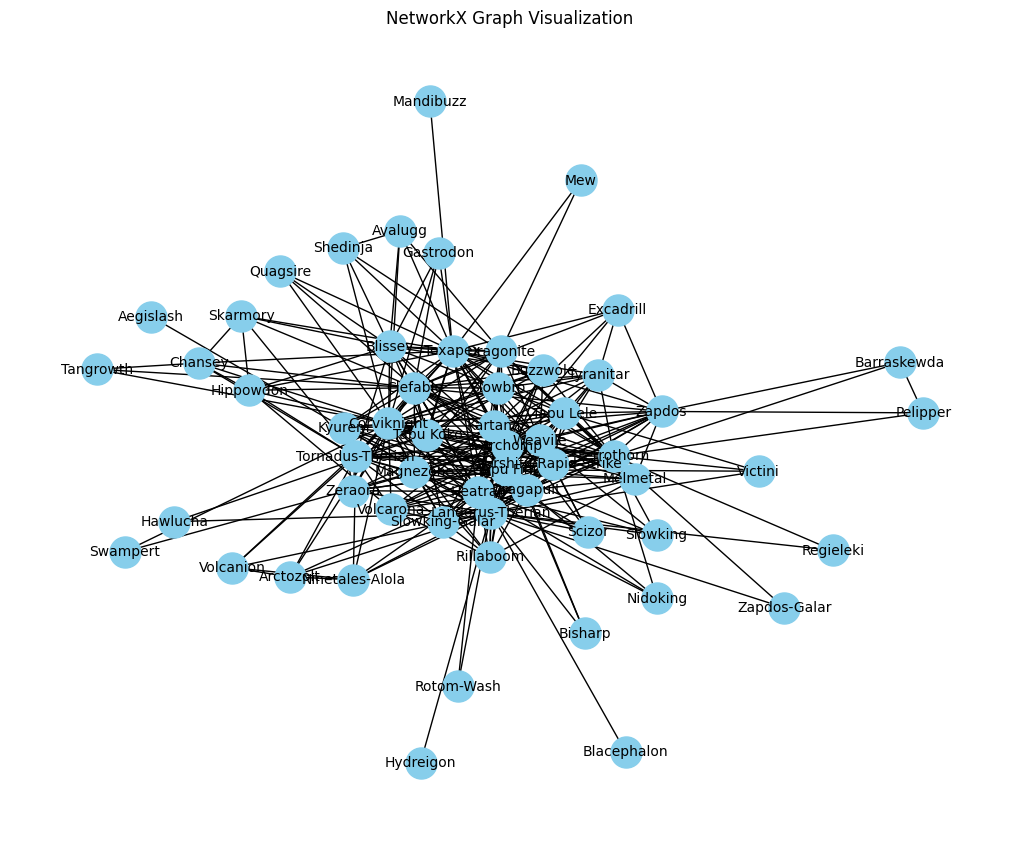

In [ ]:
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='black', linewidths=1, font_size=10)
plt.title("NetworkX Graph Visualization")
plt.show()

In [ ]:
print(vectors_df.isna().sum())

pokemon_id      0
pokemon_name    0
x               0
y               0
dtype: int64


In [ ]:
print(edge_list_df.isna().sum())

source_id      0
source_name    0
target_id      0
target_name    0
edge_weight    0
dtype: int64


In [ ]:
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
import random
import numpy as np
from tqdm import tqdm
from typing import List

# Load CSV into pandas DataFrame
df = pd.read_csv("pkmn.csv")

# Preprocess data to remove quotes around node names
df['source_name'] = df['source_name'].str.replace('"', '')
df['target_name'] = df['target_name'].str.replace('"', '')

# Create a directed graph
g = nx.from_pandas_edgelist(df, source="source_name", target="target_name", edge_attr="edge_weight", create_using=nx.DiGraph())

class DeepWalk:
    def __init__(self, window_size: int, embedding_size: int, walk_length: int, walks_per_node: int):
        """
        :param window_size: window size for the Word2Vec model
        :param embedding_size: size of the final embedding
        :param walk_length: length of the walk
        :param walks_per_node: number of walks per node
        """
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.walk_length = walk_length
        self.walk_per_node = walks_per_node

    def random_walk(self, g: nx.Graph, start: str, use_probabilities: bool = False) -> List[str]:
        """
        Generate a random walk starting on start
        :param g: Graph
        :param start: starting node for the random walk
        :param use_probabilities: if True take into account the weights assigned to each edge to select the next candidate
        :return:
        """
        walk = [start]
        for i in range(self.walk_length):
            neighbours = g.neighbors(walk[i])
            neighs = list(neighbours)
            if use_probabilities:
                probabilities = [g.get_edge_data(walk[i], neig)["edge_weight"] for neig in neighs]
                sum_probabilities = sum(probabilities)
                probabilities = list(map(lambda t: t / sum_probabilities, probabilities))
                p = np.random.choice(neighs, p=probabilities)
            else:
                p = random.choice(neighs)
            walk.append(p)
        return walk

    def get_walks(self, g: nx.Graph, use_probabilities: bool = False) -> List[List[str]]:
        """
        Generate all the random walks
        :param g: Graph
        :param use_probabilities:
        :return:
        """
        random_walks = []
        for _ in range(self.walk_per_node):
            random_nodes = list(g.nodes)
            random.shuffle(random_nodes)
            if len(random_nodes) > 0:
                for node in tqdm(random_nodes):
                    random_walks.append(self.random_walk(g=g, start=node, use_probabilities=use_probabilities))
        return random_walks

    def compute_embeddings(self, walks: List[List[str]]):
        """
        Compute the node embeddings for the generated walks
        :param walks: List of walks
        :return:
        """
        model = Word2Vec(sentences=walks, window=self.window_size, vector_size=self.embedding_size)
        return model.wv

# Initialize DeepWalk parameters
window_size = 5
embedding_size = 64
walk_length = 20
walks_per_node = 10

# Initialize DeepWalk
deepwalk = DeepWalk(window_size, embedding_size, walk_length, walks_per_node)

# Generate random walks
walks = deepwalk.get_walks(g, use_probabilities=False)

# Compute node embeddings
node_embeddings = deepwalk.compute_embeddings(walks)

for node_name in g.nodes:
    if node_name in node_embeddings:
        embedding_vector = node_embeddings[node_name]
        print("Embedding vector for node '{}':".format(node_name))
        print(embedding_vector)
    else:
        print("Node '{}' not found in the embeddings.".format(node_name))


100%|██████████| 57/57 [00:00<00:00, 20865.36it/s]


Embedding vector for node 'Slowking-Galar':
[ 0.27441248 -0.03673143  0.38763937 -0.00827009 -0.00212377 -0.3793044
  0.17410392  0.24837467 -0.1587686  -0.06429251  0.2191735  -0.08798955
  0.07911988 -0.03637758  0.04583565  0.05542452 -0.03057984  0.00381531
 -0.0358147   0.313677    0.12286918  0.20324446  0.35883924 -0.07137246
 -0.09530505  0.42280215 -0.23727727  0.05263355  0.07669092 -0.17372361
 -0.2036405   0.08499853 -0.46949667 -0.31926882  0.01839705  0.04150302
 -0.00160212  0.21828915  0.39881104  0.0522935   0.01563683  0.06645098
 -0.02750668 -0.16234383  0.09009543 -0.00370221 -0.04041006 -0.21995723
 -0.0285168   0.1836888  -0.00570988  0.08919652  0.09745096  0.36616537
  0.31321454  0.29611573  0.14168327 -0.20457833 -0.08233958 -0.11901724
  0.15766305 -0.25096264 -0.07603768  0.158617  ]
Embedding vector for node 'Tornadus-Therian':
[ 0.2823324  -0.05787134  0.40200576 -0.01995776 -0.00297433 -0.42027488
  0.18468632  0.25325596 -0.18472478 -0.07835572  0.266654

In [ ]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec

# Load the CSV file into a DataFrame
df = pd.read_csv('pkmn.csv')

# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(df, 'source_name', 'target_name', ['edge_weight'])

# Collect edge weight nodes to be added to the graph
edge_weight_nodes = []
for u, v, d in G.edges(data=True):
    weight = d['edge_weight']
    edge_weight_nodes.append(((u, v), {'weight': weight}))

# Add edge weight nodes to the graph
G.add_nodes_from(edge_weight_nodes)

# Generate embeddings using Node2Vec
node2vec = Node2Vec(G, dimensions=3, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Get the embeddings for each edge weight node
edge_weight_embeddings = {node: model.wv[node] for node in G.nodes() if isinstance(node, tuple)}

# Display embeddings
for edge, embedding in edge_weight_embeddings.items():
    print(f"Edge Weight: {edge}, Embedding: {embedding}")



Computing transition probabilities:   0%|          | 0/391 [00:00<?, ?it/s]

Edge Weight: ('"Slowking-Galar"', '"Tornadus-Therian"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [ 0.1804961  -0.59379536  1.9481623 ]]
Edge Weight: ('"Slowking-Galar"', '"Clefable"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [-0.1992734  -0.32510692  2.0021641 ]]
Edge Weight: ('"Slowking-Galar"', '"Weavile"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [ 0.17863402 -0.15885636  1.9905745 ]]
Edge Weight: ('"Slowking-Galar"', '"Urshifu-Rapid-Strike"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [ 0.15292665 -0.04569643  1.9956806 ]]
Edge Weight: ('"Slowking-Galar"', '"Corviknight"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [ 0.06353303 -0.45164067  1.9784353 ]]
Edge Weight: ('"Slowking-Galar"', '"Dragapult"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [ 0.21462063 -0.14239597  1.9879047 ]]
Edge Weight: ('"Slowking-Galar"', '"Volcarona"'), Embedding: [[ 0.2486417  -0.13512336  1.9816314 ]
 [ 0.20609152 -0.28725448  1.9663584 ]]
Edg

In [ ]:
pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

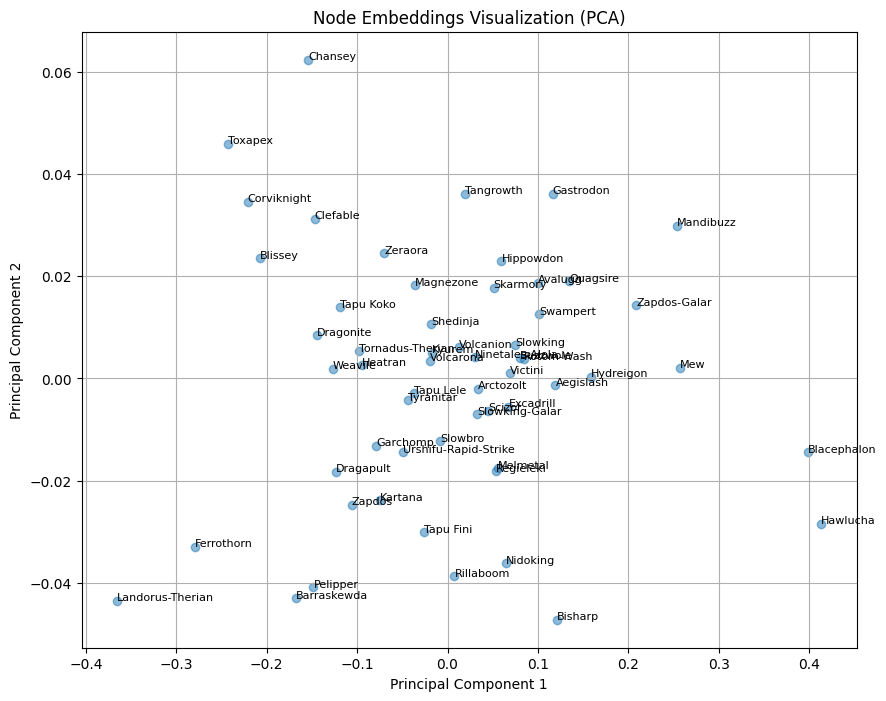

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality of embeddings using PCA
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(node_embeddings.vectors)

# Extract x and y coordinates
x = embedding_2d[:, 0]
y = embedding_2d[:, 1]

# Plot embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x, y, alpha=0.5)

# Annotate points with Pokémon names
for i, txt in enumerate(node_embeddings.index_to_key):
    plt.annotate(txt, (x[i], y[i]), fontsize=8)

plt.title("Node Embeddings Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [ ]:
import networkx as nx

# Perform Louvain's community detection on the original graph
partition = nx.community.greedy_modularity_communities(g)

# Create a dictionary to map nodes to their assigned community
node_community_map = {}
for i, community in enumerate(partition):
    for node in community:
        node_community_map[node] = i

# Print community assignments for each node
for node_name, community_id in node_community_map.items():
    print(f"Node '{node_name}' belongs to community {community_id}.")



Node 'Volcanion' belongs to community 0.
Node 'Scizor' belongs to community 0.
Node 'Aegislash' belongs to community 0.
Node 'Hawlucha' belongs to community 0.
Node 'Arctozolt' belongs to community 0.
Node 'Slowking' belongs to community 0.
Node 'Kyurem' belongs to community 0.
Node 'Nidoking' belongs to community 0.
Node 'Ninetales-Alola' belongs to community 0.
Node 'Tapu Koko' belongs to community 0.
Node 'Rotom-Wash' belongs to community 0.
Node 'Zeraora' belongs to community 0.
Node 'Hydreigon' belongs to community 0.
Node 'Heatran' belongs to community 0.
Node 'Landorus-Therian' belongs to community 0.
Node 'Blacephalon' belongs to community 0.
Node 'Mew' belongs to community 1.
Node 'Chansey' belongs to community 1.
Node 'Blissey' belongs to community 1.
Node 'Tangrowth' belongs to community 1.
Node 'Corviknight' belongs to community 1.
Node 'Tornadus-Therian' belongs to community 1.
Node 'Avalugg' belongs to community 1.
Node 'Shedinja' belongs to community 1.
Node 'Dragonite' 

In [ ]:
# Form a team of 6 Pokémon, selecting one from each community
team = []
for community in partition:
    # Select a random Pokémon from the community
    random_pokemon = random.choice(list(community))
    team.append(random_pokemon)
    if len(team) >= 6:
        break

# In case there are less than 6 communities detected, randomly select remaining Pokémon
if len(team) < 6:
    remaining_pokemon = [pokemon for pokemon in g.nodes() if pokemon not in team]
    random.shuffle(remaining_pokemon)
    for pokemon in remaining_pokemon[:6 - len(team)]:
        team.append(pokemon)

print("Team of 6 Pokémon:")
for pokemon in team:
    print(pokemon)

Team of 6 Pokémon:
Arctozolt
Shedinja
Victini
Pelipper
Barraskewda
Tangrowth


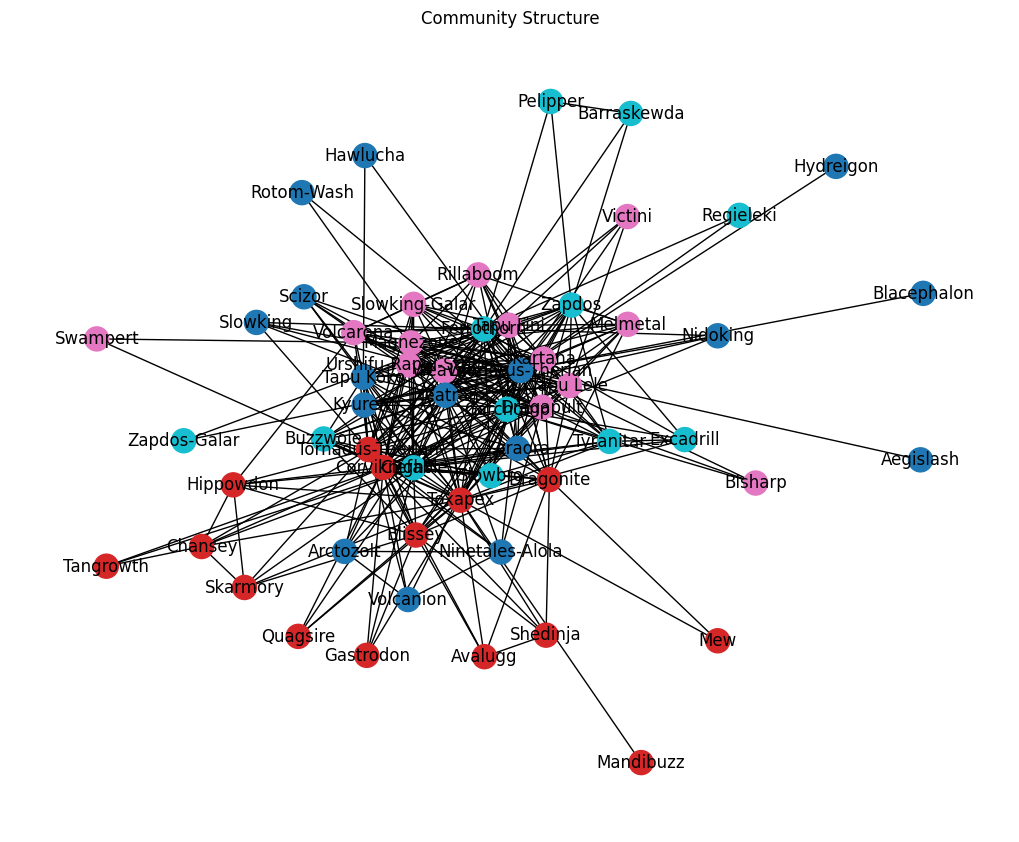

In [ ]:
import matplotlib.pyplot as plt

# Create a new graph for visualizing communities
community_graph = nx.Graph()

# Add nodes from the original graph to the community graph
community_graph.add_nodes_from(g.nodes)

# Add edges from the original graph to the community graph
community_graph.add_edges_from(g.edges)

# Draw the community graph with nodes colored by their community membership
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
pos = nx.spring_layout(community_graph)  # Define layout
# Color nodes by community
node_colors = [node_community_map[node] for node in community_graph.nodes]
nx.draw(community_graph, pos, node_color=node_colors, cmap=plt.cm.tab10, with_labels=True, node_size=300)
plt.title('Community Structure')
plt.show()


In [ ]:
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder

# Read the CSV file containing edge information
edge_list = r"pkmn.csv"
edge_list_df = pd.read_csv(edge_list, delimiter=",")

# Create a graph
G = nx.Graph()
for index, row in edge_list_df.iterrows():
    source_name = row['source_name'].strip('"')  # Remove the double quotation marks
    target_name = row['target_name'].strip('"')  # Remove the double quotation marks
    relationship_type = row['edge_weight']
    G.add_edge(source_name, target_name, weight=relationship_type)

# Create a LabelEncoder to encode Pokémon names to unique integer indices
label_encoder = LabelEncoder()
label_encoder.fit(list(G.nodes()))

# Encode node names to integers
encoded_nodes = label_encoder.transform(list(G.nodes()))

# Define edge index
edges = [(label_encoder.transform([edge[0]])[0], label_encoder.transform([edge[1]])[0]) for edge in G.edges()]
edges = list(zip(*edges))
edge_index = torch.tensor(edges, dtype=torch.long)

# Define target labels (the same as the encoded nodes)
target = torch.tensor(encoded_nodes, dtype=torch.long)

# Define node features (identity matrix for each node)
num_nodes = len(G.nodes())
node_features = torch.eye(num_nodes)  # Identity matrix as node features

# Define Graph Convolutional Network (GCN) model
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Define model parameters
input_dim = num_nodes  # Input dimension is the number of nodes
hidden_dim = 64
output_dim = num_nodes  # Output dimension is the number of nodes

# Instantiate the model
model = GCNModel(input_dim, hidden_dim, output_dim)

# Set the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Define a function to train the model
def train_model(model, node_features, edge_index, target, optimizer, criterion, epochs=1000):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(node_features, edge_index)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the model
train_model(model, node_features, edge_index, target, optimizer, criterion)

# Get node embeddings
with torch.no_grad():
    embeddings = model(node_features, edge_index)

# Recommend Pokémon based on node embeddings (select Pokémon with highest embedding values)
recommended_pokemon_indices = embeddings.argmax(dim=0).tolist()

# Map node indices back to Pokémon names
recommended_pokemon = label_encoder.inverse_transform(recommended_pokemon_indices)

# Print recommended Pokémon
print("Recommended Pokémon based on GCN embeddings:")
for pokemon in recommended_pokemon:
    print(pokemon)

# Get the top 6 Pokémon based on embedding values
top_pokemon_indices = torch.argsort(embeddings.sum(dim=1), descending=True)[:6]

# Map node indices back to Pokémon names
top_pokemon = label_encoder.inverse_transform(top_pokemon_indices.tolist())

# Print the top 6 recommended Pokémon
print("Top 6 recommended Pokémon:")
for pokemon in top_pokemon:
    print(pokemon)




Epoch 1, Loss: 4.0423583984375
Epoch 2, Loss: 4.020765781402588
Epoch 3, Loss: 3.999154806137085
Epoch 4, Loss: 3.975594997406006
Epoch 5, Loss: 3.9491357803344727
Epoch 6, Loss: 3.920027732849121
Epoch 7, Loss: 3.8888046741485596
Epoch 8, Loss: 3.8561675548553467
Epoch 9, Loss: 3.8226563930511475
Epoch 10, Loss: 3.7885680198669434
Epoch 11, Loss: 3.7532432079315186
Epoch 12, Loss: 3.715984344482422
Epoch 13, Loss: 3.6761600971221924
Epoch 14, Loss: 3.6336212158203125
Epoch 15, Loss: 3.588935613632202
Epoch 16, Loss: 3.542632579803467
Epoch 17, Loss: 3.4950215816497803
Epoch 18, Loss: 3.4461100101470947
Epoch 19, Loss: 3.395756483078003
Epoch 20, Loss: 3.3439533710479736
Epoch 21, Loss: 3.2906699180603027
Epoch 22, Loss: 3.2360341548919678
Epoch 23, Loss: 3.180170774459839
Epoch 24, Loss: 3.123260974884033
Epoch 25, Loss: 3.065586566925049
Epoch 26, Loss: 3.007101058959961
Epoch 27, Loss: 2.947812795639038
Epoch 28, Loss: 2.887760877609253
Epoch 29, Loss: 2.8270421028137207
Epoch 30, L